# Community Sampling

In [1]:
from collections import namedtuple
from itertools import cycle

from os.path import join, exists
from os import makedirs, chdir,getcwd,fchmod
from glob import glob
import shutil

import time

import numpy as np

import pandas as pd

import re

import scipy as sc
from scipy.stats import norm
from scipy.stats import expon
import scipy.interpolate as interpolate
import scipy.integrate
from scipy.fftpack import fft, ifft

from lmfit.models import Model
from lmfit import conf_interval

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

from Bio.Seq import MutableSeq
from Bio.Alphabet import IUPAC

import docker

import configparser

import seaborn as sns
sns.set_context("paper")

## Definitions

In [2]:
def create_mount_run(image,mount_dir,cmd,envs):
    if envs:    
        container = cli.create_container(
            image=image, command=cmd, volumes=['/mnt/vol'],
            host_config=cli.create_host_config(binds={
                mount_dir: {
                    'bind': '/mnt/vol',
                    'mode': 'rw',
                }
            }),
            environment=envs
        )
    else:
        container = cli.create_container(
            image=image, command=cmd, volumes=['/mnt/vol'],
            host_config=cli.create_host_config(binds={
                mount_dir: {
                    'bind': '/mnt/vol',
                    'mode': 'rw',
                }
            })
        )
    ctr=container.get('Id')
    cli.start(ctr)
    cli.wait(ctr,60*60*24*10)
    return cli.logs(ctr)

In [3]:
def Gekv(B,C):
    return 2**(1 - B)/(C*np.log(2))*(1 - 2**(-C))

In [4]:
def Gekv(C,D):
    return 2**(C + D)/(C*np.log(2))*(1 - 2**(-C))

In [5]:
def Asnok(R,C,D,l):
    return R/(Gekv(C,D) * l)
    #R_{ij} & = G_{eqv,ij} \, l_{ij} \, A_{ij}

In [6]:
Asnok(.6,.5,.3,1)

0.40776824535522777

0.38168014374858189

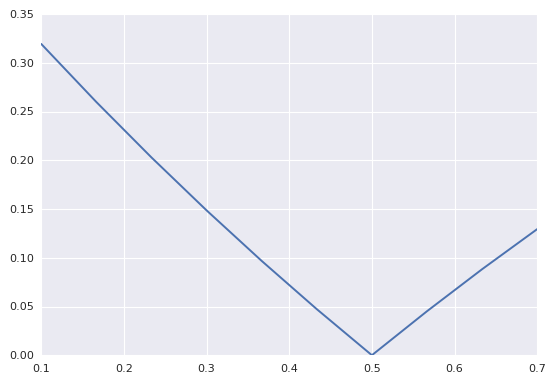

In [7]:
cc=np.linspace(0.1,.7,10)
plt.plot(cc,np.abs(Asnok(.6,.3,.5,1)-Asnok(.6,.3,cc,1))/Asnok(.6,.3,.5,1))
Asnok(.6,.3,.5,1)

In [8]:
#create_mount_run('sysbio-chalmers/menace',td,['ptr_pipeline.py -c /mnt/vol/comm0/project.conf fetch-references','-s',join('/mnt/vol/comm0/','acc')],'')

In [9]:
#create_mount_run('sysbio-chalmers/menace',td,'python ptr_pipeline.py -c /mnt/vol/comm0/project.conf -h','')

In [36]:
class Community:
    "A community defined by genome references (Biopython SeqRecords) and corresponding growth parameters."
    def __init__(self,name,acc,growth_param,td,mapper,image,env,email):
        self.name = name
        self.conf = local_conf(join(td,name),mapper,email)
        self.d_conf = local_conf(join('/mnt/vol',name),mapper,email)
        self.args0=['menace','-c',join(self.d_conf['node_path'],'project.conf')]
        self.env=env
        self.image=image
        
        self.create_dirs(True)
        save_config(self.conf,self.d_conf)
        self.fetch_ref(acc)
        
        self.pop = self.init_population(acc,growth_param)
        self.distribution = self.community_distribution()
        self.samples = []
        
    def init_population(self,acc,growth_param):
        records=open_records(glob(join(self.conf['ref_path'],'Fasta','*.fasta')))
        population = namedtuple("population", "B C D l seq cells")
        
        #refId=[x.id for x in records]
        #acc=keys(comm)
        #refInd=[acc.index(x) for x in refId]
        
        pop = {}
        
        #for i,rec in enumerate(records):
        # add [:-2] to a if . removed 
        for i,a in enumerate(acc): 
            pop[a]=population(B = growth_param[i][0],C = growth_param[i][1],
                             D = growth_param[i][2], l = len(records[a]),
                             seq = records[a], cells=growth_param[i][3])
        return pop
    
    def ptr(self):
        for i,a in enumerate(self.pop.keys()):
            print a+": "+str(2**growth_param[i][1])
    
    def community_distribution(self):
        d=np.array([Gekv(p.B,p.C)*p.l*p.cells for p in self.pop.values()])
        return d/d.sum()

    #def ab_(self):   
    #    return 
    
    def sample(self,nr_samples):
        nr_samples=np.array(nr_samples*self.distribution)
        nr_samples=nr_samples.astype(np.int)
        
        samp_run=[]
        for i,p in enumerate(self.pop.keys()):
            samp_run.append(inverse_transform_sampling(self.pop[p].C,nr_samples[i],self.pop[p].l))
        
        self.samples.append(samp_run)
    
    def write_reads(self):
        for i,samp in enumerate(self.samples):
            write_reads(samp,self,self.conf['data_path'],self.name+str(i))
    
    def compare_fit(self):
        if not self.samples:
            print "The community is not sampled, please run community.sample(nr_samples)"
            return;
        
        err_hfit=[]
        err_pfit=[]
        res_fit=[]
        
        for i,samp in enumerate(self.samples):
            for acc in self.pop.keys():
                try:
                    depth_file=join(self.conf['output_path'],self.name+str(i),'npy',acc+'.depth.npy')
                    best_file=join(self.conf['output_path'],self.name+str(i),'npy',acc+'.depth.best.npy')

                    signal=2**(np.load(depth_file))
                    signal=signal/(signal.sum()/len(signal))#*self.pop[acc].l)
                    from_ptr=np.load(best_file)

                    res=fit_signal(signal,self.pop[acc].l)
                    res_fit.append(res)
                    
                    err_hfit.append((self.pop[acc].C-res.best_values['C'])/self.pop[acc].C)

                    err_pfit.append((self.pop[acc].C-from_ptr[2]+from_ptr[3])/self.pop[acc].C)
                    print "Simulated value: "+str(self.pop[acc].C)
                    print "Error from this fit: "+str(err_hfit[-1])+ ' value: ' + str(res.best_values['C'])
                    print "Error from initial PTR fit "+str(err_pfit[-1])+' value: ' + str(from_ptr[2]-from_ptr[3])
                except Exception as Ex:
                    print "Ex"
                    pass
        return [res_fit,err_hfit,err_pfit]
    
    
    def fetch_ref(self,acc=''):
        acc_path = join(self.conf['node_path'],"acc")
        f = open(acc_path, "w")
        
        if not acc:
            f.write("\n".join(self.pop.keys()))
        else:
            f.write("\n".join(acc))
        f.close()
        
        create_mount_run(self.image,td,self.args0+['fetch-references','-s',join(self.d_conf['node_path'],'acc')],self.env)

    def build_index(self):
        create_mount_run(self.image,td,self.args0+['build-index'],self.env)

    def run_pipeline(self):
        create_mount_run(self.image,td," ".join(['/bin/bash -c "']+self.args0+['make']+[';']+self.args0+['run"']),self.env)
        
    def collect(self):
        create_mount_run(self.image,td,self.args0+['collect'],self.env)
        
    def create_dirs(self,from_init=False):
        if exists(self.conf['node_path']) and from_init:
            shutil.rmtree(self.conf['node_path'])
        
        for d in [self.conf['node_path'],self.conf['data_path'],self.conf['output_path'],self.conf['ref_path']]:
            if not exists(d):
                makedirs(d)

    #def complexity(self):
        #len(self.pop)
        #return complexity

In [11]:
import numpy as np

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [12]:
def pxn(x, C, l):
    return (2**(1 + C - (2*C*x)/float(l))*C*np.log(2))/(float(l)*(-1 + 2**C))

In [13]:
def pxn2(x, C):
    return (2**(1 + C - (2*C*x))*C*np.log(2))/((-1 + 2**C));

In [14]:
def piecewise_prob(x,C,l):
    conds=[(0 < x) & (x <= float(l)/2), x > float(l)/2]
    funcs=[lambda x: pxn(x,C,l)/float(2),lambda x: pxn((l-x),C,l)/float(2)]
    return np.piecewise(x,conds,funcs)

In [15]:
def piecewise_prob2(x,C):
    conds=[(0 < x) & (x <= float(1)/2), x > float(1)/2]
    funcs=[lambda x: pxn(x,C,1)/float(2),lambda x: pxn2((1-x),C,1)/float(2)]
    return np.piecewise(x,conds,funcs)

In [16]:
def inverse_transform_sampling(C,n_samples,l=1):
    x = np.linspace(0, float(1)/1.7, 100)
    y = np.linspace(pxn(.5,C,1),pxn(0,C,1),100)

    pdf=interpolate.interp1d(x,pxn(x,C,1))
    cdf = [scipy.integrate.quad(lambda x: pdf(x),0,i)[0] for i in np.linspace(0,.5,100)]
    inv_cdf = interpolate.interp1d(cdf, np.linspace(0,.5,100))
    
    r = np.random.rand(n_samples)
    v=l*np.round(inv_cdf(r[:int(n_samples/2)]),4)
    v2=l*(1-np.round(inv_cdf(r[int(n_samples/2):]),4))
    v=np.concatenate([v,v2])
    
    return v.astype(np.int)

In [17]:
def read_pair(header,ind,seq,pos,l):
    def circular_yield(x,pos,sub,l):
        if (pos>l):
            return x[pos-l:pos-l+sub]
        elif (pos+sub>l):
            r=pos+sub-l
            x2=x[pos:pos+sub-r]
            return x2+x[0:r]
        else:
            return x[pos:pos+sub]

    #base_error_rate = .02
    #mutation_rate = .001
    #nuc=["A","C","G","T"]
    
    # generate a normally distributued insert size of mean 300 and sd 40 
    #insert_size = int(norm.rvs(size=1,loc=300,scale=30)[0])
    insert_size = int(500)
    
    r1 = circular_yield(seq,pos,100,l)
    r2 = circular_yield(seq,pos+insert_size,100,l)
    
    # flip reads according to seqs error and mutation rate
    #ra=[]
    #for r in [r1,r2]:
    #    rr=np.random.random(100)
    #    m_ind=[i for i,j in enumerate(rr) if j < base_error_rate]
    #    char=np.random.choice(nuc,len(m_ind))
    #    a=list(r)
    #    for i,ind in enumerate(m_ind):
    #        a[ind]=char[i] 
    #    ra.append("".join(a))
        #r_tmp=r_tmp[:m_ind[0]]
        #for i,index in enumerate(m_ind[1:]):
        #    r_tmp = r_tmp[:index] + char[i] + r[index + 1:]
    #[r1,r2]=ra

    #nrs=[str(np.random.randint(low=1000,high=2000)),str(np.random.randint(low=10**4,high=2*10**4)),str(np.random.randint(low=10**5,high=2*10**5))]
    rec1=SeqRecord(r1,id=header+"_"+str(pos)+"."+str(ind),description="RANDXXLAB"+str(pos)+"_"+str(pos+insert_size+100)+":0:0"+"/1")
    rec2=SeqRecord(r2,id=header+"_"+str(pos)+"."+str(ind),description="RANDXXLAB"+str(pos)+"_"+str(pos+insert_size+100)+":0:0"+"/2")
    #rec1=SeqRecord(r1,id=header+"."+str(ind),description="FCB00YLABXX:6:"+nrs[0]+":"+nrs[1]+":"+nrs[2]+"/1")
    #rec2=SeqRecord(r2,id=header+"."+str(ind),description="FCB00YLABXX:6:"+nrs[0]+":"+nrs[1]+":"+nrs[2]+"/2")
    
    #rec1=SeqRecord(r1,id=header+"_"+str(pos)+"_"+str(pos+insert_size)+"/1",description="")
    #rec2=SeqRecord(r2,id=header+"_"+str(pos)+"_"+str(pos+insert_size)+"/2",description="")
    rec2=rec2.reverse_complement(id=header+"_"+str(pos)+"."+str(ind),description="RANDXXLAB"+str(pos)+"_"+str(pos+insert_size+100)+":0:0"+"/2")
    #rec2=SeqRecord(r2,id=header+"."+str(ind)+"/2",description="")
    rec1.letter_annotations['phred_quality']=[17]*100
    rec2.letter_annotations['phred_quality']=[17]*100
    
    #rec1.description=
    
    return(rec1,rec2)
    

In [18]:
def open_records(fasta):
    records={};
    for f in fasta:
        handle = open(f, "rU")
        tmp=list(SeqIO.parse(handle, "fasta"))
        m=re.match('.*(N[CTZ]_([A-Z]{2})*[0-9]{6}).*',tmp[0].id)
        records[m.group(0)]=tmp[0].seq
        handle.close()
    
    return records

In [19]:
def write_reads(samples,comm,directory,name):
    f1 = open(join(directory,name+"_1.fastq"), "w")
    f2 = open(join(directory,name+"_2.fastq"), "w")
    
    for i,p in enumerate(comm.pop.keys()):
        for j,pos in enumerate( samples[i].tolist()):
            r1,r2 = read_pair(name+"_"+p,str(j+1),comm.pop[p].seq,pos,comm.pop[p].l)

            SeqIO.write(r1, f1, "fastq")
            SeqIO.write(r2, f2, "fastq")
    
    f1.close()
    f2.close()

In [20]:
def plot_samples(samples):
    y=[np.bincount(s) for s in samples]
    for p in y:
        plt.plot(p/float(p.sum()),marker='.',linestyle='None')

In [21]:
def local_conf(td,mapper,email):   
    return {
            'project': 'ptr_simulation',
            'cluster': '',
            'job_name': 'ptr_simulation',
            'job_nodes': '1',
            'cpu_cores': '4',
            'estimated_time': '',

            'node_path': td,
            'ref_path': join(td,'References'),
            'data_path': join(td,'Data'),
            'output_path': join(td,'Out'),
            'doric_path': join(td,'DoriC'),

            'mapper': mapper,
            'ref_name': 'sim',
            'nr_samples': '1',
            'samples_per_node': '1',
            'email': email,
            'data_prefix': '',
            'start_ind': '1',
            'job_range': '1',

            'ftp_url': '',
            'data_url': ''
        }

In [22]:
def run_community_analysis(exec_string,td,mapper,acc,growth_param,community,nr_samples,topname):
    chdir(td)
    comm=[]
    docker_td='/mnt/vol'
    
    for i,c in enumerate(community):
        accs=[acc[x] for x in c]
        grs=[growth_param[x] for x in c]

        wd='comm_'+str(topname)+str(i)
        docker_fd=join(docker_td,wd)
        fd=join(td,wd)
        
        # create dirs
        if 'd' in exec_string:
            if exists(fd):
                shutil.rmtree(fd)
            for d in [wd,join(wd,'Data'),join(wd,'Out')]:
                if not exists(d):
                    makedirs(d)
        
        chdir(wd)
        lconf=local_conf(fd,mapper)
        conf=local_conf(docker_fd,mapper)
        save_config(lconf,conf)
        
        args0=['/home/Programs/PTR-Pipeline/ptr_pipeline.py','-c',join(conf['node_path'],'project.conf'),'-e','hedani@chalmers.se']
        
        if 'f' in exec_string:
            f = open("acc", "w")
            f.write("\n".join(accs))
            f.close()

            create_mount_run('centos/hedani',td,args0+['fetch-references','-s',join(conf['node_path'],'acc')])

        if 's' in exec_string:
            # create community and sample
            # name,acc,growth_param,td,mapper
            comm.append(Community(wd,accs,grs,td,'bowtie2'))
            comm[i].sample(nr_samples)
            comm[i].write_reads()

        if 'b' in exec_string: create_mount_run('centos/hedani',conf['node_path'],args0+['build-index'])

        if 'm' in exec_string: create_mount_run('centos/hedani',conf['node_path'],args0+['make'])

        if 'r' in exec_string: create_mount_run('centos/hedani',conf['node_path'],args0+['run'])

        #chdir('..')
        
    return comm

In [23]:
def fit_signal(signal,l):
    x1=np.linspace(0,1,len(signal))
    
    piecewiseModel=Model(piecewise_prob)
    piecewiseModel.set_param_hint('l',     value=1,vary=False)
    piecewiseModel.set_param_hint('C',   vary=True,  value=.1,min=0,max=1)
    piecewiseModel.make_params()
    
    res=piecewiseModel.fit(signal,x=x1,weights=np.sin(1.5*x1)+1.5)
    return res

In [24]:
def save_config(lconf,conf):
    Config = configparser.ConfigParser()
    Config.optionxform = str
    
    cfgfile = open(join(lconf['node_path'],'project.conf'),'w')

    Config.add_section('Project')
    Config.set('Project','ProjectID',conf['project'])
    Config.set('Project','Cluster',conf['cluster'])
    Config.set('Project','JobName',conf['job_name'])
    Config.set('Project','JobNodes',conf['job_nodes'])
    Config.set('Project','CpuCores',conf['cpu_cores'])
    Config.set('Project','EstimatedTime',conf['estimated_time'])
    
    Config.add_section('Directories')
    Config.set('Directories','Node',conf['node_path'])
    Config.set('Directories','References',conf['ref_path'])
    Config.set('Directories','Data',conf['data_path'])
    Config.set('Directories','Output',conf['output_path'])
    Config.set('Directories','DoriC',conf['doric_path'])
    
    Config.add_section('Other')
    Config.set('Other','Mapper',conf['mapper'])
    Config.set('Other','RefName',conf['ref_name'])
    Config.set('Other','NrSamples',conf['nr_samples'])
    Config.set('Other','SamplesPerNode',conf['samples_per_node'])
    Config.set('Other','Email',conf['email'])
    Config.set('Other','DataPrefix',conf['data_prefix'])
    Config.set('Other','StartInd',conf['start_ind'])
    Config.set('Other','JobRange',conf['job_range'])
    Config.set('Other','FtpURL',conf['ftp_url'])
    Config.set('Other','DataURL',conf['data_url'])
    
    Config.write(cfgfile)
    cfgfile.close()

In [25]:
def mutation_run():
    rec.seq=mutateSeq(mutable_seq,.01)
    
    MutableSeq(str(rec.seq), IUPAC.unambiguous_dna)
    
    rec.id="mut_"+rec.id
    rec.description="mut_"+rec.description
    rec.name="mut_"+rec.name
    with open(sys.argv[2], "w") as output_handle:
        SeqIO.write(rec, output_handle, "fasta")

In [26]:
def compare_fit(c):
    err_hfit=[]
    err_pfit=[]
    res_fit=[]
    
    header=['C','Error','ACC','Coverage','Method','Sample']
    df=pd.DataFrame([],columns=header)
    
    #ab=pd.read_csv(join(c.conf['output_path'],'Collect','Abundance.csv'),sep=';')
    
    for i,samp in enumerate(c.samples):
        #ab_t=ab[c.name+str(i)]
        res_fit_tmp=[]
        err_hfit_tmp=[]
        err_pfit_tmp=[]
        
        for acc in c.pop.keys():
            try:
                depth_file=join(c.conf['output_path'],c.name+str(i),'npy',acc+'.depth.npy')
                best_file=join(c.conf['output_path'],c.name+str(i),'npy',acc+'.depth.best.npy')

                signal=2**(np.load(depth_file))
                signal=signal/(signal.sum()/len(signal))#*self.pop[acc].l)
                
                # extra deblurring
                signal=smooth_signal(signal,10**3)
                signal=sharpen_filter(signal)
                
                from_ptr=np.load(best_file)

                res=fit_signal(signal,c.pop[acc].l)
                #res_fit_tmp.append(res.best_values['C'])

                err_hfit_tmp=np.abs(c.pop[acc].C-res.best_values['C'])/c.pop[acc].C
                df=df.append(pd.DataFrame([[res.best_values['C'],err_hfit_tmp,acc,c.samples[0][i].size/float(c.pop[acc].l),'H',i]],columns=header),ignore_index=True)
                #err_pfit_tmp.append((c.pop[acc].C-from_ptr[2]+from_ptr[3])/c.pop[acc].C)
                #print "Simulated value: "+str(c.pop[acc].C)
                #print "Error from this fit: "+str(err_hfit_tmp[-1])+ ' value: ' + str(res.best_values['C'])
                #print "Error from initial PTR fit "+str(err_pfit_tmp[-1])+' value: ' + str(from_ptr[2]-from_ptr[3])
            except Exception as Ex:
                print Ex
                pass
        
        #res_fit.append(res_fit_tmp)
        #err_hfit.append(err_hfit_tmp)
        #err_pfit.append(err_pfit_tmp)
    return df#[res_fit,np.abs(err_hfit),np.abs(err_pfit)]

In [27]:
#cmd=['/bin/bash -c "']+['cd /mnt/vol ; /home/Programs/PTR-Pipeline/extra/ptrc_commands.sh']+['comm00_1.fastq']+['comm0_2.fastq"']
#create_mount_run('centos/hedani',td," ".join(cmd),envs)

In [28]:
def compare_fit_ptrc(c):
    #ptrc=[]
    #ptre=[]
    
    header=['C','Error','ACC','Coverage','Method','Sample']
    df=pd.DataFrame([],columns=header)
    
    for i,samp in enumerate(c.samples):
        ptrc_tmp=[]
        ptre_tmp=[]
        cmd=['/bin/bash -c "']+['cd /mnt/vol ; /home/Programs/PTR-Pipeline/extra/ptrc_commands.sh']+[c.name+str(i)+'_1.fastq']+[c.name+str(i)+'_2.fastq"']
        create_mount_run('centos/hedani',td," ".join(cmd),envs)
        ptr_file=join(c.conf['output_path'],'ptrc_out')
        ptrc_frame=pd.read_pickle(ptr_file)
        ind_val=ptrc_frame.index.values
        for ind in ind_val:#range(ptrc_frame.shape[0]):
            ptrc_tmp=ptrc_frame.loc[ind]['sm']#.ix[i]['sm'])
            ptre_tmp=np.abs(np.log2(ptrc_frame.loc[ind]['sm'])-c.pop[ind[:-1]].C)/c.pop[ind[:-1]].C
            df=df.append(pd.DataFrame([[np.log2(ptrc_tmp),ptre_tmp,ind[:-1],c.samples[0][i].size/float(c.pop[ind[:-1]].l),'K',i]],columns=header),ignore_index=True)
            
        #ptrc.append(ptrc_tmp)
        #ptre.append(ptre_tmp)
       
    return df

In [29]:
def mv_filt(L,omega):
    return (1/float(L))*(1-np.exp(-omega*1j*L))/(1-np.exp(-omega*1j))

In [30]:
def smooth_signal(signal,length):
    xi=np.linspace(0,1,len(signal))
    xi2=np.linspace(0,1,length)
    iss=scipy.interpolate.UnivariateSpline(xi,signal,k=3)
    iss.set_smoothing_factor(.00001)
    return iss(xi2)

In [31]:
def sharpen_filter(signal):
    x = np.linspace(-0.00001*np.pi/float(1), 1*np.pi/float(1),10**3)
    return np.roll(ifft(fft(signal,10**3)/mv_filt(1.27,x))[0:len(signal)],np.int64(-125/2))

In [32]:
def triangle(length, amplitude, y_offset):
    section = length // 4
    for direction in (1, -1):
        for i in range(section):
            yield y_offset + i * (amplitude / section) * direction
        for i in range(section):
            yield y_offset + (amplitude - (i * (amplitude / section))) * direction

In [91]:
df = pd.DataFrame([], columns=list('AB'))
df2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('AB'))
df.append(df2)

,A,B
0,5.0,6.0
1,7.0,8.0


In [ ]:
real_c=np.tile([growth_param[sel[0][1]][1],growth_param[sel[0][0]][1]],(5,1))
ptrc_e=np.abs(np.log2(ptrc)-real_c)/real_c

In [119]:
create_mount_run('menace',td," ".join(cmd),'')

'HOSTNAME=32f1e4ebca92\nBITSEQ_DIR=/opt/BitSeq\nPATH=/opt/conda/bin:/opt/PTR-Pipeline:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin\nPWD=/\nLANG=C.UTF-8\nMENACE_DIR=/opt/PTR-Pipeline\nSHLVL=1\nHOME=/root\nCONDA_DIR=/opt/conda\nCONDA_VER=4.2.12\n_=/usr/bin/env\n'

In [101]:
cmd=['/bin/bash -c "']+['cd /mnt/vol/comm0 ; ptr_pipeline.py -c project.conf fetch-references -s acc"']

In [118]:
cmd=['/bin/bash -c "']+['env"']

In [29]:
cmd=['/bin/bash -c "']+['cd /mnt/vol ; /home/Programs/PTR-Pipeline/extra/ptrc_commands.sh']+[c.name+str(0)+'_1.fastq']+[c.name+str(0)+'_1.fastq"']

In [30]:
" ".join(cmd)

'/bin/bash -c " cd /mnt/vol ; /home/Programs/PTR-Pipeline/extra/ptrc_commands.sh comm00_1.fastq comm00_1.fastq"'

In [35]:
ptrc=pd.read_pickle(ptr_file)

In [36]:
ptrc.index.values

array(['NC_000913.3\n'], dtype=object)

In [34]:
ptr_file=join(c.conf['output_path'],'ptrc_out')

In [716]:
ptrc.loc['Escherichia coli\n']['sm']

1.3020408163265316

In [662]:
ptrc=compare_fit_ptrc(c)

In [ ]:
ab=pd.read_csv(join(c.conf['output_path'],'Collect','Abundance.csv'),sep=';')

In [176]:
ab

,Name,ut/comm00,ut/comm01,ut/comm02
0,Escherichia coli,1.0,1.0,1.0


In [100]:
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2','sysbio-chalmers/menace',envs,'hedani@chalmers.se')

KeyError: 'NC_000913.3'

## Run

In [33]:
acc=['NC_000913.3','NC_007779.1','NC_002655.2','NC_009614.1','NC_017218.1']
growth_param=[[.2, .5, .3, 100],[.2, .5, .3, 100],[.2, .5, .3,100],[0.0001, .8, .2, 100],[.1, .7, .2,100]]
sel=[[0]]
td='/Users/Shared/CommTest'
accessions=[acc[s] for s in sel[0]]
community_params=[growth_param[s] for s in sel[0]]

In [80]:
c.distribution

NameError: name 'c' is not defined

In [519]:
c.pop.keys()[0]

'NC_017218.1'

In [451]:
[c.pop[i].C for i in c.pop.keys()]

[0.7, 0.8, 0.5]

In [521]:
c.samples[0][0].size/float(c.pop[c.pop.keys()[0]].l)

0.008124625132975752

In [525]:
c.pop[c.pop.keys()[1]].l

5163189

In [34]:
cli = docker.Client(base_url='unix://var/run/docker.sock')
img = 'centos/hedani'
envs = docker.utils.parse_env_file(join(td,'env_centos'))
#envs=''

In [105]:
community_arguments={"name":'comm0',
                     "acc":accessions,
                     "growth_param":community_params,
                     "td":td,
                     "mapper":"bowtie2",
                     "image":"sysbio-chalmers/menace",
                     "env":"",
                     "email":"hedani@chalmers.se"}

In [37]:
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2',img,envs,'hedani@chalmers.se')
c.build_index()
tot_reads=np.linspace(10**5,10**5,1)
for nr in tot_reads:
    c.sample(nr)
c.write_reads()
c.run_pipeline()
c.collect()

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/quadpack.py:293: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/quadpack.py:293: UserWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg)


In [126]:
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2','menace',envs,'hedani@chalmers.se')
c.sample(10**4)

In [88]:
c.write_reads()

In [ ]:
c.build_index()

In [ ]:
c.run_pipeline()

In [335]:
c.collect()

In [89]:
totH=compare_fit(c)

In [90]:
totK=compare_fit_ptrc(c)

In [91]:
totH

,C,Error,ACC,Coverage,Method,Sample
0,0.458089,0.083823,NC_000913.3,0.021544,H,0.0


In [92]:
totK

,C,Error,ACC,Coverage,Method,Sample
0,0.034108,0.931784,NC_000913.3,0.021544,K,0.0


In [48]:
create_mount_run('sysbio-chalmers/menace',td,'echo hej','')

'/bin/echo: /bin/echo: cannot execute binary file\n'

In [36]:
header=['C','Error','ACC','Coverage','Method','Sample']
totH = pd.DataFrame([], columns=header)
totK = pd.DataFrame([], columns=header)
tot = pd.DataFrame([], columns=header)
for i in range(1):
    c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2',envs,'sysbio-chalmers/menace','hedani@chalmers.se')

    c.build_index()

    tot_reads=np.linspace(10**5,10**5,1)
    for nr in tot_reads:
        c.sample(nr)

    c.write_reads()

    totK=totK.append(compare_fit_ptrc(c),ignore_index=True)
    #[k_c,k_err]=

    c.run_pipeline()

    #[res,hfit,pfit]=
    
    
    totH=totH.append(compare_fit(c),ignore_index=True)

tot=totH
tot=tot.append(totK,ignore_index=True)

APIError: 500 Server Error: Internal Server Error ("json: cannot unmarshal object into Go value of type string")

In [428]:
tot=totH
tot=tot.append(totK,ignore_index=True)

In [209]:
totK.drop('CError', axis=1, inplace=True)

ValueError: labels ['CError'] not contained in axis

In [205]:
totH.drop('Error', axis=1, inplace=True)

In [469]:
tot_nopatho=totH_nopatho
tot_nopatho=tot_nopatho.append(totK_nopatho,ignore_index=True)

In [509]:
tot_nopatho_nomult=totH
tot_nopatho_nomult=tot_nopatho_nomult.append(totK,ignore_index=True)

In [512]:
tot_nopatho_nomult

,C,Error,ACC,Coverage,Method,Sample
0,0.569772,0.186040,NC_017218.1,0.008125,H,0.0
1,0.800628,0.000785,NC_009614.1,0.003662,H,0.0
2,0.445322,0.109357,NC_000913.3,0.004074,H,0.0
3,0.358048,0.283905,NC_000913.3,0.004074,K,0.0
4,0.592122,0.259847,NC_009614.1,0.003662,K,0.0
5,0.399270,0.429614,NC_017218.1,0.008125,K,0.0


In [210]:
totH=totH.rename(index=str, columns={"C": "C", "CError": "Error","ACC":"ACC","Coverage":"Coverage","Method":"Method"})

In [354]:
tot2['Coverage']=tot2['Coverage'].round(3)
totH['Coverage']=totH['Coverage'].round(3)

In [305]:
meanErr=np.array(list(tot2[tot2['ACC']=='NC_017218.1']['Error'])+list(tot2[tot2['ACC']=='NC_000913.3']['Error']))/2

In [279]:
to_pickle('/Users/hedani/Documents/Projects/.pickle')

In [224]:
import pickle

In [480]:
pkl_file = open('/Users/hedani/Documents/Projects/df_long_run2.pickle', 'rb')

In [481]:
tot2=pickle.load(pkl_file)

In [239]:
ax.get_figure().savefig('/Users/Shared/output.pdf')

In [ ]:
tot2.drop('ACC', axis=1)

In [492]:
tot

,C,Error,ACC,Coverage,Method,Sample
0,0.557952,0.202926,NC_017218.1,0.008125,H,0.0
1,0.764662,0.044173,NC_009614.1,0.003662,H,0.0
2,0.470411,0.059177,NC_000913.3,0.004074,H,0.0
3,0.358048,0.283905,NC_000913.3,0.004074,K,0.0
4,0.592122,0.259847,NC_009614.1,0.003662,K,0.0
5,0.399270,0.429614,NC_017218.1,0.008125,K,0.0


(0, 0.6)

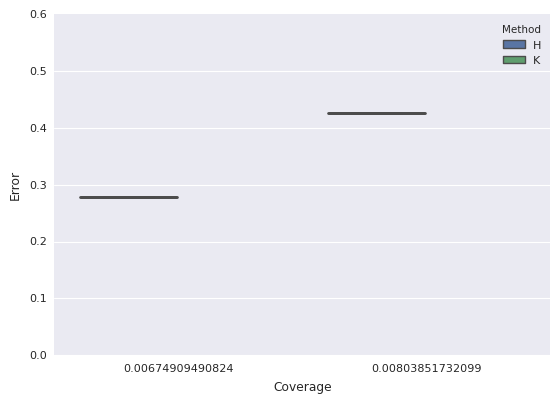

In [528]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#data=tot.drop('ACC', axis=1)
ax = sns.boxplot(x="Coverage", y="Error", hue="Method",data=tot.drop('ACC', axis=1), linewidth=2,fliersize=0,ax=ax)
#g = sns.jointplot(x="Coverage", y="Error", data=tot2)
#plt.xticks(rotation=45)
ax.set_ylim(0,.6)
#plt.xticks(FormatStrFormatter('%.2f'))
#ax.set(xlabel='Error', ylabel='Coverage')
#ax.fig.get_axes()[0].set_xticklabels(["Menace", "Ptr"])

In [490]:
c.distribution

array([ 0.18910612,  0.4355671 ,  0.37532678])

In [2]:
tot

NameError: name 'tot' is not defined

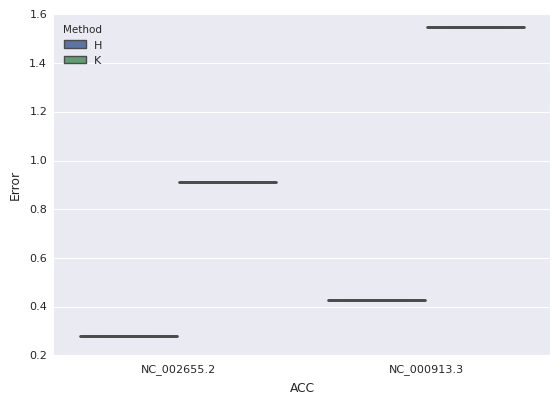

In [529]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="ACC", y="Error", hue="Method",data=tot, linewidth=2,fliersize=0,ax=ax)

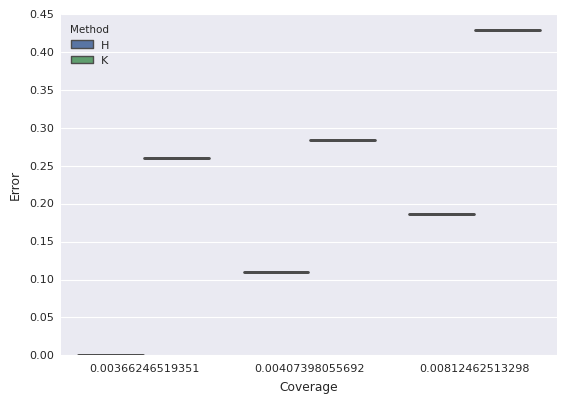

In [510]:
fig, ax = plt.subplots()
#data=tot.drop('ACC', axis=1)
ax = sns.boxplot(x="Coverage", y="Error", hue="Method",data=tot_nopatho_nomult.drop('ACC', axis=1), linewidth=2,fliersize=0,ax=ax)
#g = sns.jointplot(x="Coverage", y="Error", data=tot2)
#plt.xticks(rotatio

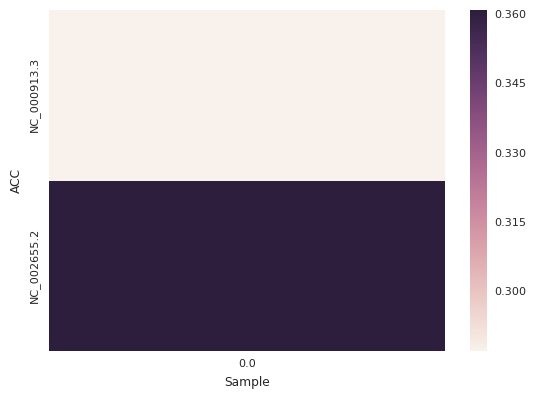

In [534]:
tot_piv = totH.ix[0:9].pivot("ACC", "Sample", "C")
ax = sns.heatmap(tot_piv)

In [486]:
tot.corr()

,C,Error,Coverage,Sample
C,1.000000,-0.632426,-0.301773,NaN
Error,-0.632426,1.000000,0.549970,NaN
Coverage,-0.301773,0.549970,1.000000,NaN
Sample,NaN,NaN,NaN,NaN


ValueError: Could not interpret input 'Coverage'

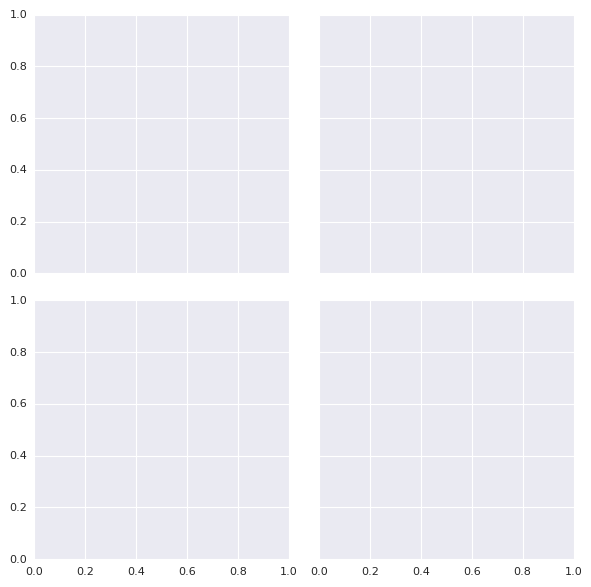

In [267]:
g = sns.FacetGrid(tot2, col="ACC", row="Method", margin_titles=True)
g.map(sns.boxplot,y="Error",x="Coverage", data=tot)

In [237]:
plt.savefig('/Users/Shared/output.png')

In [240]:
tips = sns.load_dataset("tips")

TypeError: load_dataset() takes at least 1 argument (0 given)

In [726]:
[k_c,k_err]=compare_fit_ptrc(c)

KeyboardInterrupt: 

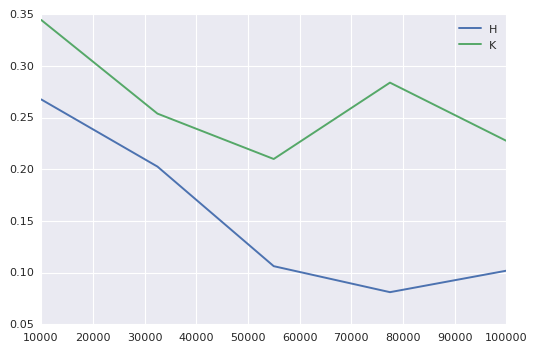

In [708]:
plt.plot(tot_reads,np.mean(hfit,1),tot_reads,np.mean(ptrc_e,1))#,tot_reads,[r[0].best_values['C'],r[1].best_values['C'] for r in res])
legend = plt.legend(['H','K'])
#ax = plt.axes()
#ax.set_title('Mean absolute error')
#g.fig.suptitle('THIS IS A TITLE, YOU BET')

In [232]:
pwd

u'/Users/hedani/Documents/GitRepos/PTRloc/PTR-Pipeline/extra'

In [234]:
ax.savefig("/Users/Shared/output.pdf")

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [280]:
args0=['/home/Programs/PTR-Pipeline/ptr_pipeline.py','-c',join('/mnt/vol','comm0','project.conf'),'-e','hedani@chalmers.se']          
create_mount_run('centos/hedani',td," ".join(['/bin/bash -c "']+args0+['make']+[';']+args0+['run"']),envs)

"Running alignment stage\ncomm00:\nAligning comm00:\n99999 reads; of these:\n  99999 (100.00%) were paired; of these:\n    99690 (99.69%) aligned concordantly 0 times\n    147 (0.15%) aligned concordantly exactly 1 time\n    162 (0.16%) aligned concordantly >1 times\n    ----\n    99690 pairs aligned concordantly 0 times; of these:\n      47312 (47.46%) aligned discordantly 1 time\n    ----\n    52378 pairs aligned 0 times concordantly or discordantly; of these:\n      104756 mates make up the pairs; of these:\n        57 (0.05%) aligned 0 times\n        4319 (4.12%) aligned exactly 1 time\n        100380 (95.82%) aligned >1 times\n99.97% overall alignment rate\nMoving into subjobs\ncomm00: Running pathoscope stage\nRunning without mySQLdb library\ncomm00: Running coverage stage\ncomm00: Sorting\ncomm00: Calculating coverage\ncomm00: Performing piecewise fits\nNC_000913.3\nNC_000913.3.depth\nNC_000913.3.depth: Bin coverage too low, exiting.\nNC_009614.1\nNC_009614.1.depth\nNC_009614.1.

In [507]:
res=fit_signal(st,1)
err_hfit=((.5-res.best_values['C'])/.5)
err_hfit

0.8969818062406385

In [464]:
res.best_values['C']

0.50223664098758436

In [496]:
#depth_file=join(c.conf['output_path'],c.name+'0','npy',c.pop.keys()[0]+'.depth.npy')
depth_file='/Users/Shared/CommTest/comm0/Out/comm00/npy/NC_000913.3.depth.npy'

In [53]:
depth_file='/Users/hedani/Documents/GitRepos/PTRloc/tt/Out/comm00/npy/NC_000913.3.depth.npy'

In [54]:
signal=2**np.load(depth_file)
signal=signal/(signal.sum()/len(signal))

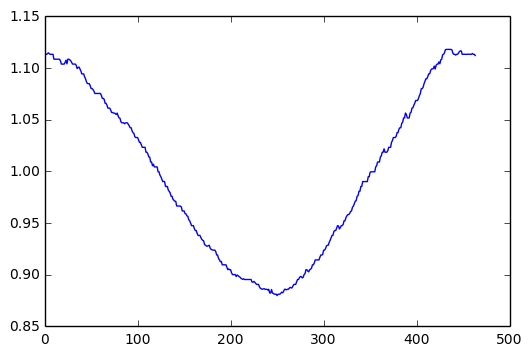

In [509]:
plt.plot(signal)

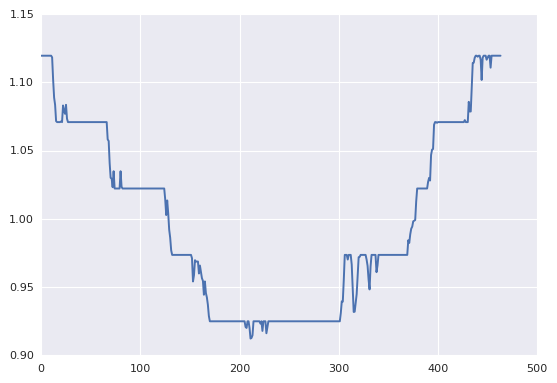

In [55]:
plt.plot(signal)

In [429]:
 x = np.linspace(-2*np.pi, 2*np.pi, len(signal))

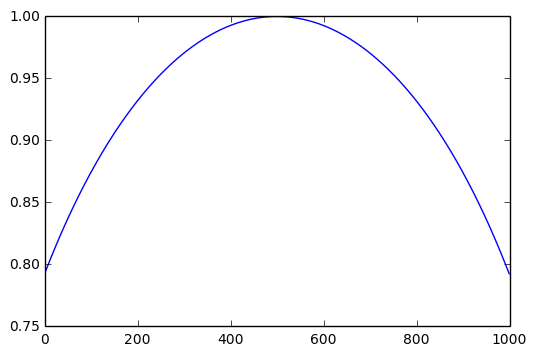

In [339]:
xx=np.linspace(-np.pi, np.pi, 1000)
plt.plot(np.abs(mv_filt(1.2,xx)))

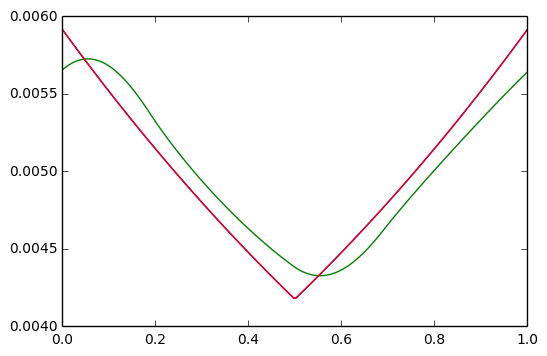

In [401]:
y2=[]
x2=np.linspace(0,.5,100)
y2=np.append(pxn2(x2,.5),pxn2(x2,.5)[::-1])
x2=np.linspace(0,1,200)

y=list(triangle(1000, 0.1,10))
x=range(len(y))
x_p = np.linspace(-2*np.pi, 2*np.pi, len(y2))

f=mv_filt(20,x_p)
fft_y=fft(y2)*f
smooth_y=np.roll(ifft(fft_y),0)
smooth_y=smooth_y/np.sum(smooth_y)

x3=np.linspace(0,1,len(y_long))
y_skum=y_long/(np.sum(y_long+np.mean(y_long)))
x_p2 = np.linspace(-2*np.pi, 2*np.pi, len(y_skum))

plt.plot(x2,y2/np.sum(y2),x2,smooth_y,x2,ifft(fft(smooth_y)/f))

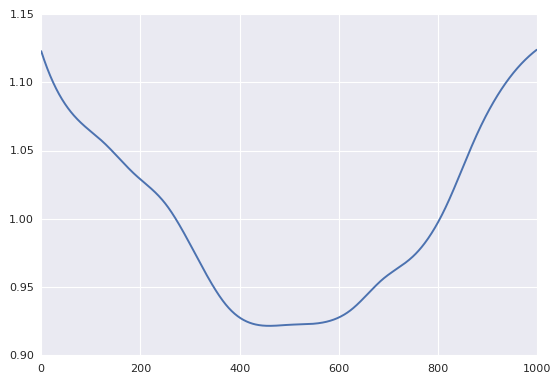

In [60]:
xi=np.linspace(0,1,len(signal))
xi2=np.linspace(0,1,10**3)
iss=scipy.interpolate.UnivariateSpline(xi,signal,k=3)
iss.set_smoothing_factor(.05)
y_long=iss(xi2)
plt.plot(y_long)

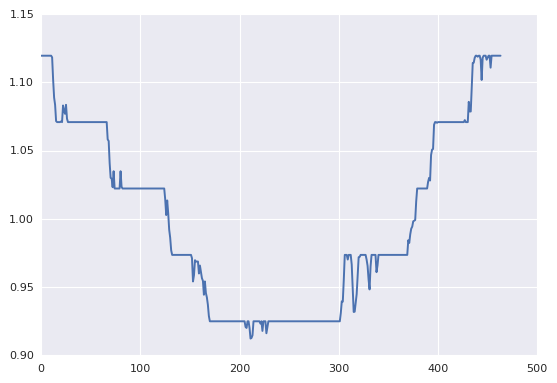

In [61]:
plt.plot(np.abs(ifft(fft(signal,10**4))[0:len(signal)]))

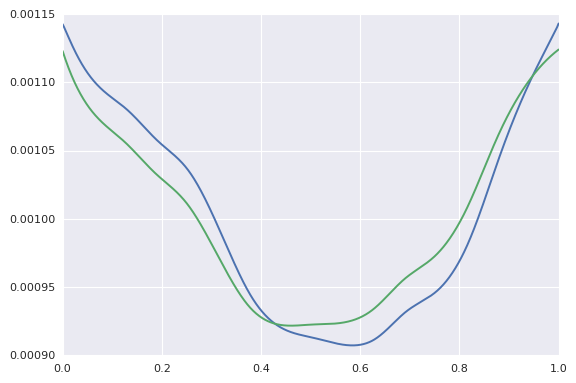

In [65]:
signal=y_long
x = np.linspace(-0.00001*np.pi/float(1), 1*np.pi/float(1),10**3)
st=np.roll(ifft(fft(signal,10**3)/mv_filt(1.27,x))[0:len(signal)],np.int64(-0/2))
x2=np.linspace(0,1,len(st))
x1=np.linspace(0,1,len(signal))
plt.plot(x2,st/np.sum(st),x1,signal/np.sum(signal))

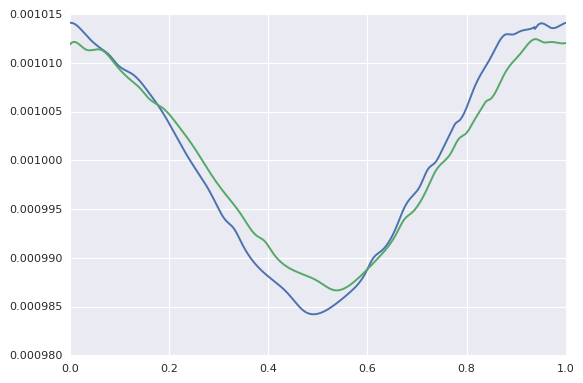

In [514]:
plt.plot(x2,st/np.sum(st),x1,signal/np.sum(signal))

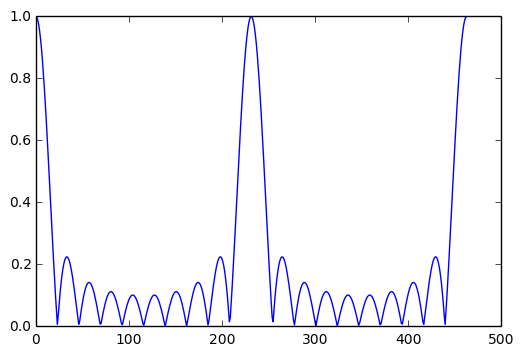

In [193]:
plt.plot(np.abs(mv_filt(1*10**1,x)))

In [411]:
np.sqrt(-1)

nan

In [ ]:
1+np.exp()

In [398]:
np.exp(1)

2.7182818284590451

In [272]:
create_mount_run('centos/hedani',td," ".join(['/bin/bash -c "']+['which python"']),envs)

'/usr/bin/python\n'

In [52]:
tot_reads=[10**5]#np.linspace(5*10**3,10**4,15)
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2')
c.build_index()
for nr in tot_reads:
    c.sample(nr)
    c.write_reads()

c.run_pipeline()
[res,hfit,pfit]=c.compare_fit()

NotFound: 404 Client Error: Not Found ("{"message":"oci runtime error: exec: \"-e\": executable file not found in $PATH"}")

In [247]:
community=[]
nrs=np.linspace(10**5,10**5,1)
res=[]
for nr in nrs:
    community.append(run_community_analysis('fs',td,'bowtie2',acc,growth_param,sel,nr,0))
    #res.append(community[i][0].compare_fit())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Python/2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/Library/Python/2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1049, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/usr/local/Cellar/python/2.7.11/Frameworks/Python.framework/Versions/2.7/lib/python2.7/inspec

IndexError: string index out of range

In [73]:
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2')

KeyError: 'NC_000913.3'

In [47]:
tot_reads=[10**5]#np.linspace(5*10**3,10**4,15)
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2')
c.build_index()

IOError: [Errno 2] No such file or directory: '/mnt/vol/comm0/project.conf'

In [2132]:
n=130;
D1_snok=np.random.randint(30,40);C1_snok=np.random.randint(40,70);tau1_snok=np.random.randint(130,250,n)
#tau1_snok[-1]=50;
D2_snok=10.;C2_snok=35.;tau2_snok=np.random.randint(60,200,n)
ab1=[np.random.rand() for x in range(n)];ab2=np.random.randint(100,200,n);
org1=[[np.max([1-(C1_snok+D1_snok)/float(tau1_snok[i]),0]),(C1_snok)/float(tau1_snok[i]), (D1_snok)/float(tau1_snok[i]),ab1[i]] for i in range(tau1_snok.size)]
org2=[[1-(C2_snok+D2_snok)/float(tau2_snok[i]),(C2_snok)/float(tau2_snok[i]), (D1_snok)/float(tau2_snok[i]),ab2[i]/float(ab1[i])] for i in range(tau2_snok.size)]

#same_org[0][0]=0

In [2133]:
print D1_snok,C1_snok

34 44


In [2134]:
same_org=np.concatenate((org1,org2))

In [2135]:
Ri1

array([ 0.12517895,  0.28003121,  0.11440445,  0.15001599,  0.07173145,
        0.32649918,  0.39299506,  0.01202917,  0.34304507,  0.33282179,
        0.04329798,  0.26181841,  0.33872681,  0.14846477,  0.24897509,
        0.061663  ,  0.2401119 ,  0.40135043,  0.2886033 ,  0.39829411,
        0.1850574 ,  0.34708688,  0.20622304,  0.16787013,  0.16767945,
        0.37298813,  0.33103408,  0.25134168,  0.35186729,  0.16303172,
        0.30711971,  0.26330621,  0.12609793,  0.20625785,  0.3764792 ,
        0.22850401,  0.0450059 ,  0.0809682 ,  0.18655135,  0.00784618,
        0.29397322,  0.08577948,  0.29319743,  0.10284626,  0.30304625,
        0.28011791,  0.1960176 ,  0.16534839,  0.02916867,  0.0991715 ,
        0.0578688 ,  0.27499659,  0.027967  ,  0.13073409,  0.15571648,
        0.01069903,  0.1112608 ,  0.18262335,  0.20584184,  0.3887354 ,
        0.38976375,  0.38220299,  0.36039617,  0.10669672,  0.22368446,
        0.23371822,  0.03268177,  0.25700886,  0.07782686,  0.37

In [2136]:

Ri1=np.array([Gekv2(p[1],p[2])*1*p[3] for p in org1])
rs=np.random.randint(2,3,n);
for i in range(n):
    Ri1[i]=Ri1[i]/rs[i];
    org1[i][3]=org1[i][3]/rs[i];


Ki1=np.array([(2**(p[1])-1)/(float(p[1])*np.log(2)) for p in org1])
Ri2=np.array([Gekv2(p[1],p[2])*1*p[3] for p in org2])
Ki2=np.array([(2**(p[1])-1)/(float(p[1])*np.log(2)) for p in org2])

In [2137]:
org1

[[0.64864864864864868,
  0.1981981981981982,
  0.15315315315315314,
  0.46079501691747554],
 [0.59375, 0.22916666666666666, 0.17708333333333334, 0.20116365324132957],
 [0.67088607594936711,
  0.18565400843881857,
  0.14345991561181434,
  0.49654154079404594],
 [0.57837837837837835,
  0.23783783783783785,
  0.1837837837837838,
  0.24764121123035404],
 [0.60999999999999999, 0.22, 0.17, 0.3921142465319019],
 [0.6637931034482758,
  0.1896551724137931,
  0.14655172413793102,
  0.20158666914294182],
 [0.6637931034482758,
  0.1896551724137931,
  0.14655172413793102,
  0.22483740954130388],
 [0.65638766519823788,
  0.19383259911894274,
  0.14977973568281938,
  0.22464293403338875],
 [0.50943396226415094,
  0.27672955974842767,
  0.2138364779874214,
  0.44063274576640726],
 [0.60204081632653061,
  0.22448979591836735,
  0.17346938775510204,
  0.43008967519542796],
 [0.60606060606060608,
  0.2222222222222222,
  0.1717171717171717,
  0.17211265559073496],
 [0.52439024390243905,
  0.26829268292682

In [1887]:
np.array([Gekv2(p[1],p[2])*1*p[3] for p in org1])

array([ 1.09875756,  0.54429242,  0.14761133])

In [1888]:
[2**(p[2])*((2**(p[1])-1)/(float(p[1])*np.log(2)))*1*p[3]/400. for p in same_org]

[0.002746893895910563,
 0.0013607310513527526,
 0.00036902832344279818,
 0.58984513209798939,
 1.0191773861094746,
 5.2424783744028893]

In [939]:
cip

array([[ 0.23809524,  0.18404908],
       [ 0.23809524,  0.1875    ],
       [ 0.18404908,  0.1875    ]])

In [546]:
[c[1]/float(c[0]) for c in cip]

[1.3636363636363635, 2.9104477611940296, 2.1343283582089554]

In [545]:
[t[0]/float(t[1]) for t in tip]

[1.3636363636363635, 2.91044776119403, 2.1343283582089554]

In [2138]:
Rip1=create_pairs(Ri1)
Kip1=create_pairs(Ki1)
cip1=create_pairs([p[1] for p in org1])
tip1=create_pairs([t for t in tau1_snok])
Aip1=create_pairs([p[3] for p in org1])
Rip2=create_pairs(Ri2)
Kip2=create_pairs(Ki2)
cip2=create_pairs([p[1] for p in org2])
tip2=create_pairs([t for t in tau2_snok])
Aip2=create_pairs([p[3] for p in org2])
inde=np.triu_indices(len(Ri1),k=1)
#Aa=np.zeros(len(Rip))

#for i in len(cip):
#    Aa[i]=A_snok(Rip[i],Kip[i],[1,1],cip[i])
    
#M=np.zeros(len(sel[0]))
#for i in len(arrC):
#    M[i][j]=1-

In [1940]:
cip

array([[ 0.23809524,  0.18404908],
       [ 0.23809524,  0.1875    ],
       [ 0.18404908,  0.1875    ]])

In [2139]:
M1=np.zeros((len(Rip1),len(Ri1)))
b1=np.zeros(len(Rip1))
for i in range(len(inde[0])):
    cc=cip1[i][1]/cip1[i][0]
    M1[i][inde[0][i]]=cc
    M1[i][inde[1][i]]=-1
    b1[i]=cc*np.log2(Rip1[i][0])-np.log2(Rip1[i][1])+np.log2(Kip1[i][1])-cc*np.log2(Kip1[i][0])

In [2140]:
M2=np.zeros((len(Rip2),len(Ri2)))
b2=np.zeros(len(Rip2))
for i in range(len(inde[0])):
    cc=cip2[i][1]/cip2[i][0]
    M2[i][inde[0][i]]=cc
    M2[i][inde[1][i]]=-1
    b2[i]=cc*np.log2(Rip2[i][0])-np.log2(Rip2[i][1])+np.log2(Kip2[i][1])-cc*np.log2(Kip2[i][0])

In [1807]:
for i in range(3):
    print (Rip1[i][0]/Kip1[i][0])**(cip1[i][1]/cip[i][0])*Kip1[i][1]/Rip1[i][1]

1.38762708215
1.07528402889
1.69467827533


In [1674]:
for i in range(3):
    print (Aip1[i][0]**(cip1[i][1]/cip[i][0]))/Aip1[i][1]

0.449997988656
3.23668895758
0.358153810534


In [1505]:
for i in range(3):
    print cip1[i][1]/cip[i][0]

2.08108108108
1.57142857143
2.1654589372


In [881]:
print Kip1[1]
print Rip1[1]
print cip1[]
dd

[ 1.11527593  1.24003622]
[ 0.3560757   0.92593291]
[ 0.30927835  0.6       ]


array([ 0.27675277,  0.48214286,  0.56589147])

In [870]:
print b1

[-0.36306836 -2.77405818 -1.85186455]


In [738]:
Z1=np.zeros_like(M1);
Z2=np.zeros_like(M2);
B=np.ones(3*2);

T=np.bmat([[M1,Z1],[Z2,M2]]);
T=np.vstack((T,B));
b=np.vstack((b1,b2));

#b_sum=np.sum([-2/float(3)*x for x in np.array(org1)[:,1]]+Ri1-Ki1)
#b_sum=b_sum+np.sum([-2/float(3)*x for x in np.array(org2)[:,1]]+Ri2-Ki2)

b_sum=np.sum(-np.array(org1)[:,2]+Ri1-Ki1)
b_sum=b_sum+np.sum(-np.array(org2)[:,2]+Ri2-Ki2)


b=np.append(b,b_sum)

In [713]:
aa=np.array(org1)[:,1]

In [726]:
b_sum=np.sum([-2/float(3)*x for x in np.array(org1)[:,1]]+Ri1-Ki1)
b_sum=b_sum+np.sum([-2/float(3)*x for x in np.array(org2)[:,1]]+Ri2-Ki2)

In [727]:
b_sum

-3.987251671839438

In [761]:
dd

array([ 0.35869565,  0.28888889,  0.29962547,  0.64130435,  0.71111111,
        0.70037453])

In [511]:
sort_cip=[]*(len(cip*len(cip)))
for i in range(len(cip)):
    for j in range(len(cip)):
        sort_cip[i*len(cip)+j]=cip[i][1]/cip[i][0]*cip[j][1]/cip[j][0]
        
sort_cip=np.sort(sort_cip)

IndexError: list assignment index out of range

In [506]:
F=np.vstack((M[0],M[5],M[9],M[12],M[13],M[14]))

In [1675]:
for i in range(len(cip1)):
    print Aip1[i][1]*Kip1[i][1]/Rip1[i][1]-(Aip1[i][0]*Kip1[i][0]/Rip1[i][0])**(cip1[i][1]/cip1[i][0])

0.0
-1.11022302463e-16
-1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
0.0
1.11022302463e-16
0.0
0.0
-1.11022302463e-16
2.22044604925e-16
1.11022302463e-16
2.22044604925e-16
2.22044604925e-16
2.22044604925e-16
1.11022302463e-16
0.0
1.11022302463e-16
0.0
0.0
0.0
0.0
0.0
1.11022302463e-16
0.0
-1.11022302463e-16
-1.11022302463e-16
0.0
2.22044604925e-16
-2.22044604925e-16
2.22044604925e-16
1.11022302463e-16
1.11022302463e-16
-2.22044604925e-16
0.0
-1.11022302463e-16
0.0
-1.11022302463e-16
1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
0.0
0.0
0.0
-1.11022302463e-16
0.0
0.0
0.0
1.11022302463e-16
-1.11022302463e-16
2.22044604925e-16
-1.11022302463e-16
-1.11022302463e-16
-1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
-1.11022302463e-16
1.11022302463e-16
0.0
0.0
0.0
0.0
-1.11022302463e-16
2.22044604925e-16

In [1943]:
for i in range(len(cip1)):
    print (cip1[i][1]/cip1[i][0])*np.log2(org1[inde[0][i]][3])-np.log2(org1[inde[1][i]][3])
    print b1[i]

0.0242960306378
0.0242960306378
-0.593614405608
-0.593614405608
1.00682722112
1.00682722112
-1.39951074432
-1.39951074432
-2.7647456932
-2.7647456932
-2.6801539874
-2.6801539874
-0.816833388596
-0.816833388596
-2.71431138142
-2.71431138142
0.949758826131
0.949758826131
-0.431945024915
-0.431945024915
-4.32758429026
-4.32758429026
0.254397200383
0.254397200383
-3.20206889585
-3.20206889585
1.22175010091
1.22175010091
-2.0481735664
-2.0481735664
0.386551000023
0.386551000023
-0.601940146656
-0.601940146656
-2.79234749798
-2.79234749798
-4.62964225429
-4.62964225429
-5.63250540252
-5.63250540252
-0.28050737905
-0.28050737905
-4.4519438523
-4.4519438523
-0.00635582016726
-0.00635582016726
-4.45262640471
-4.45262640471
-1.78119266794
-1.78119266794
-5.51660757361
-5.51660757361
0.709315296884
0.709315296884
0.575700058359
0.575700058359
-3.97414611725
-3.97414611725
-0.615952936147
-0.615952936147
0.98569076397
0.98569076397
-1.42228093728
-1.42228093728
-2.79050214098
-2.79050214098
-2.705

In [877]:
np.log2(dd)

array([-1.85333035, -1.05246742, -0.8214027 ])

In [1508]:
dd=np.array([p[3] for p in org1])
dd

array([ 0.685,  0.255,  0.605,  0.515,  0.68 ,  0.435,  0.51 ,  0.365,
        0.575,  0.485])

In [879]:
print M1

[[ 0.76377953 -1.          0.        ]
 [ 1.94        0.         -1.        ]
 [ 0.          2.54       -1.        ]]


In [628]:
tau_snok[0]/float(tau_snok[1])

0.77300613496932513

In [631]:
tau_snok[0]/float(tau_snok[2])

0.78749999999999998

In [632]:
tau_snok[1]/float(tau_snok[2])

1.01875

In [1509]:
viaCellDist=np.dot(M1,np.log2(dd).T)
viaCellDist

array([ 1.40102007,  0.29427461,  0.49854699,  0.0838889 ,  0.69438792,
        0.50242643,  0.91287269,  0.27938584,  0.60117694, -0.7636385 ,
       -0.62836045, -1.07665758, -0.5497179 , -0.6495234 , -0.4163002 ,
       -0.99531275, -0.48632815,  0.18508056, -0.23893474,  0.34832098,
        0.18199408,  0.54314305, -0.07519094,  0.29867087, -0.4295401 ,
        0.14399204, -0.00719939,  0.3248429 , -0.28454436,  0.12006166,
        0.60445902,  0.41915893,  0.8167948 ,  0.18724558,  0.52256776,
       -0.14052535,  0.17100525, -0.4320772 , -0.00580551,  0.33314988,
       -0.27657783,  0.12685828, -0.59607403, -0.1457189 ,  0.36281979])

In [1510]:
b1

array([ 1.40102007,  0.29427461,  0.49854699,  0.0838889 ,  0.69438792,
        0.50242643,  0.91287269,  0.27938584,  0.60117694, -0.7636385 ,
       -0.62836045, -1.07665758, -0.5497179 , -0.6495234 , -0.4163002 ,
       -0.99531275, -0.48632815,  0.18508056, -0.23893474,  0.34832098,
        0.18199408,  0.54314305, -0.07519094,  0.29867087, -0.4295401 ,
        0.14399204, -0.00719939,  0.3248429 , -0.28454436,  0.12006166,
        0.60445902,  0.41915893,  0.8167948 ,  0.18724558,  0.52256776,
       -0.14052535,  0.17100525, -0.4320772 , -0.00580551,  0.33314988,
       -0.27657783,  0.12685828, -0.59607403, -0.1457189 ,  0.36281979])

In [797]:
print b1

[-0.13128513  0.4296232   0.49356518]


In [613]:
cip[1][1]/cip[1][0]

0.78750000000000009

In [621]:
tau_snok[2]/float(tau_snok[1])

0.98159509202453987

In [618]:
tau_snok[1]

163

In [612]:
-cip[1][1]/cip[1][0]+cip[0][1]/cip[0][0]*cip[2][1]/cip[2][0]

-1.1102230246251565e-16

In [614]:
cip

array([[ 0.23809524,  0.18404908],
       [ 0.23809524,  0.1875    ],
       [ 0.18404908,  0.1875    ]])

In [583]:
cip2=create_pairs([p[1] for p in same_org])
cip2

array([[[ 0.15384615,  0.15384615],
        [ 0.15384615,  0.20979021],
        [ 0.15384615,  0.44776119]],

       [[ 0.20979021,  0.15384615],
        [ 0.20979021,  0.20979021],
        [ 0.20979021,  0.44776119]],

       [[ 0.44776119,  0.15384615],
        [ 0.44776119,  0.20979021],
        [ 0.44776119,  0.44776119]]])

In [578]:
inde

(array([0, 0, 1]), array([1, 2, 2]))

In [560]:
yy=np.linalg.solve(M[0:6],b.T[0:6])

In [ ]:
Mt

In [1927]:
print np.linalg.pinv(Mt)

[[ 0.44711538  0.375       0.375     ]
 [-0.5         0.41935484  0.41935484]
 [ 0.59615385 -0.5         0.5       ]]


In [1928]:
np.linalg.norm(np.linalg.pinv(Mt))*np.linalg.norm(Mt)

3.8000038116125108

In [497]:
inde

(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]),
 array([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]))

In [489]:
.43*.63-.55*.49

0.0013999999999999568

In [1892]:
print D1_snok
print C1_snok
print tau1_snok

36
41
[208 186 156]


In [2116]:
M1.shape

(8385, 130)

In [2142]:
np.linalg.norm(np.linalg.pinv(Mt))*np.linalg.norm(Mt)

1404.5085861661685

In [2249]:
Mt=M1;
bt=b1;
Mt=np.append(Mt,[np.zeros(n)], axis=0);
Mt[-1][-1]=1
bt=np.append(bt,[0], axis=0);
bt[-1]=(np.log2(Ri1[-1])-np.log2(Ki1[-1])-org1[-1][2])
#bt[-1]=np.mean(np.log2(np.array(Rip1)[:,0])-np.log2(Kip1[:,0])-np.array(cip1)[:,0])
bt[-1]=np.log2(Ri1[-1])-np.log2(Ki1[-1])-cip1[-1][0]
bt[-1]=np.log2(Ri1[-1])-np.log2(Ki1[-1])-aa1[-1]
#bt[-1]=np.log2(Ahat[-25])
bt[-1]

-2.1995569268971438

In [2238]:
np.abs(np.abs(np.log2(Ri1[-1])-np.log2(Ki1[-1])-org1[-1][2])-abs(bt[-1]))/np.abs(np.log2(Ri1[-1])-np.log2(Ki1[-1])-org1[-1][2])

0.028334480029993895

In [2250]:
print np.log2(Ri1[-1])-np.log2(Ki1[-1])-org1[-1][2]
print np.log2(Ri1[-1])-np.log2(Ki1[-1])-org1[-1][1]
print np.log2(Ri1[-1])-np.log2(Ki1[-1])-cip1[-1][0]
print np.mean(np.log2(Ri1)-np.log2(Ki1)-np.array(org1)[:,1])

-2.13895086629
-2.1995569269
-2.20961981998
-2.49371103151


In [2240]:
log2Ahat=np.linalg.lstsq(Mt,bt.T)[0]
log2Ahat

array([ -1.16284802,  -2.36564177,  -1.05220777,  -2.06773073,
        -1.40065404,  -2.35363131,  -2.19614945,  -2.19834727,
        -1.24524446,  -1.268311  ,  -2.58907996,  -1.86369207,
        -2.528346  ,  -3.51509855,  -1.32066276,  -1.34286054,
        -1.12897437,  -2.46103614,  -1.15104639,  -2.88600213,
        -5.85454486,  -1.15925912,  -3.12999509,  -5.96039282,
        -5.35157626,  -2.25407526,  -6.38042136,  -1.8288698 ,
       -11.36096697,  -1.27842116,  -1.33597523,  -2.55897227,
        -2.16201715,  -3.76812388,  -3.9967352 ,  -1.89128576,
        -5.49146026,  -1.08043689,  -5.23413352,  -1.09399313,
        -2.04471817,  -1.11800707,  -1.89593104,  -6.68038374,
        -1.82731868,  -2.65336479,  -1.8736463 ,  -1.3686219 ,
        -2.27463559,  -1.72188249,  -1.20007855,  -2.209678  ,
        -4.04278334,  -1.69677531,  -6.56176623,  -1.36683063,
        -4.54535794,  -5.85398543,  -1.91666956,  -1.28482926,
        -1.11639461,  -1.38128469,  -2.54008099,  -2.76

In [2241]:
log2Ahat=np.linalg.solve(Mt,bt.T)
log2Ahat

LinAlgError: Last 2 dimensions of the array must be square

In [2242]:
Ahat=2**log2Ahat

In [2243]:
np.abs(np.log2(dd))-np.abs(np.log2(Ri1)-np.log2(Ki1)-np.array(org1)[:,2])

array([  2.22044605e-16,  -4.44089210e-16,   2.22044605e-16,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -2.22044605e-16,
        -2.22044605e-16,   4.44089210e-16,   0.00000000e+00,
         0.00000000e+00,   4.44089210e-16,   2.22044605e-16,
         2.22044605e-16,  -2.22044605e-16,   4.44089210e-16,
        -2.22044605e-16,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.22044605e-16,  -1.77635684e-15,  -4.44089210e-16,
        -2.22044605e-16,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   8.88178420e-16,
         2.22044605e-16,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   8.88178420e-16,   0.00000000e+00,
         0.00000000e+00,  -2.22044605e-16,   0.00000000e+00,
         0.00000000e+00,

In [2244]:
np.abs(np.abs(np.log2(Ri1)-np.log2(Ki1)-np.array(org1)[:,2])-abs(np.log2(Ahat)))/np.abs(np.log2(Ri1)-np.log2(Ki1)-np.array(org1)[:,2])

array([ 0.04029784,  0.02251222,  0.04177576,  0.02684346,  0.0370191 ,
        0.01865524,  0.02001975,  0.02044886,  0.05319322,  0.04191309,
        0.01989504,  0.03382429,  0.02160757,  0.02029801,  0.05591128,
        0.04101712,  0.04758506,  0.01686472,  0.05419266,  0.01857561,
        0.01039658,  0.04119999,  0.01494302,  0.01307444,  0.01296462,
        0.03346627,  0.00801961,  0.02825297,  0.00602387,  0.04049195,
        0.03178215,  0.0163444 ,  0.03342598,  0.01243913,  0.01511827,
        0.02301749,  0.00736717,  0.05207202,  0.0084879 ,  0.06828688,
        0.02162958,  0.0470625 ,  0.03973955,  0.01050447,  0.027705  ,
        0.01854439,  0.03715079,  0.05813051,  0.02919124,  0.03069678,
        0.0466386 ,  0.01866401,  0.01723406,  0.02475167,  0.00973938,
        0.03574389,  0.01074242,  0.00832103,  0.03899896,  0.05631104,
        0.05117272,  0.03570539,  0.0215056 ,  0.02593211,  0.03212416,
        0.01455136,  0.0163745 ,  0.01452604,  0.03987853,  0.04

In [2245]:
dd=np.array([p[3] for p in org1])
#aun=np.array(Ahat)/(np.mean(Ahat)/np.mean(dd));
#aun=np.array(Ahat)/(Ahat[0]/dd[0]);
print np.abs((dd-Ahat)/dd)
print Ahat

[ 0.03074045  0.03545753  0.02882317  0.0367742   0.03406367  0.02943513
  0.02943513  0.03007363  0.0426576   0.03474663  0.03440176  0.04138436
  0.03638813  0.04731582  0.04731582  0.03601009  0.03492167  0.02789526
  0.04018491  0.035824    0.04089609  0.03129557  0.0314375   0.05192249
  0.04636648  0.04933609  0.03457334  0.03423188  0.04605844  0.03389711
  0.02812159  0.02812159  0.04731582  0.03158072  0.0404192   0.02906487
  0.02745335  0.03638813  0.03007363  0.04731582  0.02956065  0.03423188
  0.04898748  0.04699509  0.03356881  0.03293094  0.04545448  0.05078156
  0.04373401  0.03492167  0.03638813  0.02767254  0.04636648  0.02800797
  0.0429217   0.0321669   0.03293094  0.03293094  0.04864377  0.04636648
  0.03697032  0.03246822  0.03638813  0.04731582  0.02778345  0.04575447
  0.02882317  0.03840398  0.0426576   0.04089609  0.03074045  0.0314375
  0.04113877  0.03777616  0.03340704  0.02870382  0.02943513  0.02812159
  0.02906487  0.03340704  0.03231686  0.03757143  0.

In [2246]:
np.log2(dd)

array([ -1.11780298,  -2.31355844,  -1.01001368,  -2.01367667,
        -1.35065404,  -2.31052786,  -2.153046  ,  -2.15429441,
        -1.18235138,  -1.2172906 ,  -2.53857491,  -1.80271646,
        -2.47487007,  -3.44516848,  -1.25073269,  -1.28995049,
        -1.07769232,  -2.42021981,  -1.0918748 ,  -2.83337055,
        -5.79430389,  -1.11338756,  -3.08391214,  -5.88346975,
        -5.28308311,  -2.18108256,  -6.32965994,  -1.77861855,
       -11.29293976,  -1.22866992,  -1.29482297,  -2.51782001,
        -2.09208708,  -3.72182758,  -3.93721139,  -1.84873257,
        -5.45129962,  -1.02696095,  -5.19008066,  -1.02406306,
        -2.00142813,  -1.06775581,  -1.82346727,  -6.6109393 ,
        -1.7780576 ,  -2.60505561,  -1.80653221,  -1.29343393,
        -2.21011946,  -1.67060043,  -1.14660261,  -2.16919217,
        -3.97429019,  -1.65579171,  -6.49847509,  -1.31966082,
        -4.49704876,  -5.80567625,  -1.84472712,  -1.21633611,
        -1.06204679,  -1.33366564,  -2.48660506,  -2.69

In [2247]:
aa=np.array(org1)[:,2];
np.abs(aa-np.abs(np.log2(Ri1)-np.log2(Ki1)-np.log2(Ahat)))/aa

array([ 0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29411765,
        0.29411765,  0.29411765,  0.29411765,  0.29411765,  0.29

In [2251]:
aa1=(np.log2(Ri1)-np.log2(Ki1)-np.log2(Ahat))

In [2252]:
aa2=(np.log2(Ri1)-np.log2(Ki1)-np.log2(Ahat))

In [2254]:
k1=aa1/np.array(org1)[:,1]
k2=aa2/np.array(org1)[:,1]
print k1

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.]


In [2100]:
aa1/aa2

array([ 1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05

In [2092]:
(np.log2(Ri1)-np.log2(Ki1)-np.log2(Ahat))/np.array(org1)[:,1]

array([ 1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05583756,
        1.05583756,  1.05583756,  1.05583756,  1.05583756,  1.05

In [2078]:
D1_snok/float(C1_snok)

0.5660377358490566

In [2107]:
np.log2(aa1/(np.array(org1)[:,1]))-np.log2(aa2/(np.array(org1)[:,1]))

array([ 0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783879,
        0.0783879,  0.0783879,  0.0783879,  0.0783879,  0.0783

In [2102]:
((aa1-aa2)/(np.array(org1)[:,1]))/()

array([ 1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00000006,
        1.00000006,  1.00000006,  1.00000006,  1.00000006,  1.00

In [2043]:
np.log2(Ri1)-np.log2(Ki1)-np.log2(Ahat)

array([ 0.27155172,  0.19364754,  0.21283784,  0.22079439,  0.29166667,
        0.30681818,  0.19207317,  0.24230769,  0.19769874,  0.21774194,
        0.2473822 ,  0.19052419,  0.3375    ,  0.22183099,  0.31711409,
        0.31711409,  0.27155172,  0.32586207,  0.2027897 ,  0.28810976,
        0.20366379,  0.20723684,  0.23275862,  0.21188341,  0.30288462,
        0.328125  ,  0.20633188,  0.28810976,  0.25132979,  0.25      ])

In [2044]:
np.array(org1)[:,2]

array([ 0.1954023 ,  0.13934426,  0.15315315,  0.1588785 ,  0.20987654,
        0.22077922,  0.13821138,  0.17435897,  0.14225941,  0.15668203,
        0.17801047,  0.13709677,  0.24285714,  0.15962441,  0.22818792,
        0.22818792,  0.1954023 ,  0.23448276,  0.14592275,  0.20731707,
        0.14655172,  0.14912281,  0.16748768,  0.15246637,  0.21794872,
        0.23611111,  0.14847162,  0.20731707,  0.18085106,  0.17989418])

In [170]:
def null(a, rtol=1e-5):
    u, s, v = np.linalg.svd(a)
    rank = (s > rtol*s[0]).sum()
    return rank, v[rank:].T.copy()

In [594]:
def create_pairs(arr):
    l=len(arr)
    arr=cartesian([arr,arr]).reshape((l,l,2))
    inde=np.triu_indices(l,k=1)
    return arr[inde]

In [74]:
l1=[x.l for x in c.pop.values()]/np.mean([x.l for x in c.pop.values()])

In [75]:
arr1=cartesian([[x.C for x in c.pop.values()],[x.C for x in c.pop.values()]])
arr1=arr1.reshape((len(sel[0]),len(sel[0]),2))
arrC=arr1[inde]

In [160]:
def A_snok(R,K,l,cik):
    return ((K[1]*l[1])/float(R[1]))*(R[0]/(float(K[0])*l[0]))**(cik[1]/float(cik[0]))

In [212]:
1**.2

1.0

In [68]:
print c.pop.keys()
print c.distribution

['NC_009614.1', 'NC_002655.2', 'NC_000913.3']
[ 0.43919776  0.40942012  0.15138212]


In [21]:
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2')

In [708]:
c.write_reads()

In [731]:
c.collect()

NameError: global name 'parser_c' is not defined

In [487]:
len(c.samples[0][0])

100000

In [709]:
c.run_pipeline()

In [512]:
[res,hfit,pfit]=c.compare_fit()

Simulated value: 0.5
Error from this fit: 0.134314081342 value: 0.432842959329
Error from initial PTR fit 0.189275182041 value: 0.405362408979


In [481]:
100*10**5/float(c.pop['NC_000913.3'].l)

2.154405371191119

In [2255]:
tot_reads=[10**6]#np.linspace(5*10**3,10**4,15)
c=Community('comm0',[acc[s] for s in sel[0]],[growth_param[s] for s in sel[0]],td,'bowtie2')
c.build_index()
for nr in tot_reads:
    c.sample(nr)
    c.write_reads()

c.run_pipeline()
[res,hfit,pfit]=c.compare_fit()

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/quadpack.py:293: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/quadpack.py:293: UserWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg)


Ex
Ex
Ex


UnboundLocalError: local variable 'res' referenced before assignment

In [448]:
np.log2(1.2978)

0.37606807113368551

In [614]:
c.distribution

array([ 0.66795389,  0.33204611])

In [616]:
c.pop.keys()

['NC_007779.1', 'NC_000913.3']

In [570]:
tot_reads[0]*100/float(c.pop['NC_000913.3'].l)

10.772026855955595

In [343]:
c.write_reads()

In [1]:
pl=plt.plot(tot_reads[0:6],hfit,tot_reads[0:6],pfit)
ax=pl[0]
#pl[0].set_xscale('log')
#plt.legend(['p(x) fit','Linear fit'])
#plt.plot(tot_reads,pfit,label='Linear fit')

NameError: name 'plt' is not defined

In [ ]:
ax.set_yscale('log')


In [270]:
[res,hfit,pfit]=c.compare_fit()

Simulated value: 0.7
Error from this fit: 0.389631075905 value: 0.427258246866
Error from initial PTR fit 0.300151361166 value: 0.489894047184
Simulated value: 0.5
Error from this fit: 0.305636070824 value: 0.347181964588
Error from initial PTR fit -0.437847123705 value: 0.718923561852


[0.1343119055981461, 0.13299914267733115]

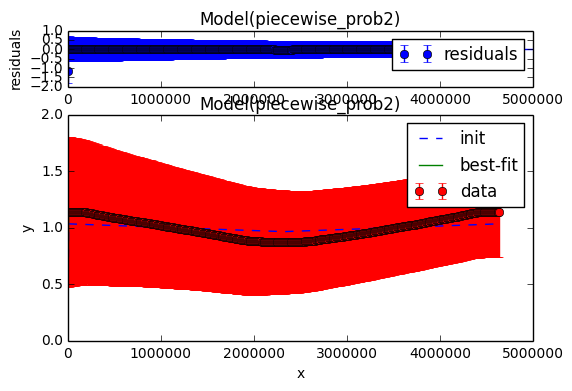

In [234]:
res.plot()
pfit

In [177]:
start = time.time()
print("hello")
end = time.time()
print(end - start)

u'/Users/hedani/Documents/GitRepos/PTRloc/PTR-Pipeline'

In [106]:
community=[]
nrs=np.linspace(5*10**3,10**6,10)
res=[]
for i in range(9):
    community.append(run_community_analysis('smr',td,'bowtie2',acc,growth_param,comm,nrs[i],0))
    res.append(community[i][0].compare_fit())

KeyError: 'NC_000913.3'

In [ ]:
cp0=community[0].pop.values()
Gekv(cp0[0].B,cp0[0].C)

In [100]:
#PTRs
for i,c in enumerate(comm):
    print "comm"+str(i)
    for c_sub in c:
        print acc[c_sub]+": "+str(2**growth_param[c_sub][1])

comm0
NC_000913.3: 1.41421356237


In [30]:
cov1=2**(np.load(join(td,'comm1/Data/reads/npy',acc[comm[1][1]]+'.depth.npy')))
acc[comm[1][1]]

'NC_002655.2'

In [58]:
#print c.pop[0].l/float(c.pop[1].l)*.8
#print c.pop[1].l/float(c.pop[0].l)*.2
c

[0, 3]

In [32]:
indd=1;
x=np.linspace(0,1,len(cov1))
plt.plot(x*c.pop[indd].l,cov1/(cov1.sum()/len(cov1)*c.pop[indd].l))
plt.plot(x*c.pop[indd].l,piecewise_prob(x*c.pop[indd].l,c.pop[indd].C,c.pop[indd].l))
plt.plot(x*c.pop[indd].l,res.best_fit)

TypeError: 'builtin_function_or_method' object has no attribute '__getitem__'

In [24]:
signal=cov1/(cov1.sum()/len(cov1)*c.pop[indd].l)
res=fit_signal(signal,c.pop[indd].l)

In [25]:
err=(c.pop[indd].C-res.best_values['C'])/c.pop[indd].C
from_ptr=np.load(join(td,'comm1/Data/reads/npy',acc[comm[1][1]]+'.depth.best.npy'))
err2=(c.pop[indd].C-from_ptr[2]+from_ptr[3])/c.pop[indd].C
print err, err2

0.0777801701655 0.104943273296


In [26]:
c.pop[indd].C

0.7

In [45]:
conf=local_conf(join(td,'comm1'),'bowtie2')

In [23]:
import example

In [48]:
example.main(join(conf['ref_path'],'Fasta'),False,conf['data_path'],conf['node_path'],conf['output_path']+"/out.df",None,True)

In [38]:
conf['ref_path']

'/mnt/comm0/References'

In [111]:
refs=open_records(glob(join(conf['ref_path'],'Fasta','*.fasta')))

In [119]:
glob(join(conf['ref_path'],'Fasta','*.fasta'))

[]

In [112]:
refs

[]

In [57]:
import PTRC

In [94]:
import pickle

In [97]:
ind

({'Bacteroides vulgatus': ['SegalLab|882']}, {})

In [101]:
f=open('/mnt/index.pk','r')
f.close()
f=open('/mnt/index.pk','w')
pickle.dump(ind,f)
f.close()

In [86]:
f=open('/mnt/index.pk','r')
ind=pickle.load(f)
pickle.save

In [93]:
ind=({'Bacteroides vulgatus': ['SegalLab|882']},{})

In [88]:
PTRC.coverage_analysis(args.i1, args.i2, args.m, args.pe, args.gz, \
                          args.outfol, args.qual_format, args.cov_thresh, dbpath = args.db_path_name)

NameError: name 'args' is not defined

In [23]:
r=glob(conf['data_path']+'/*')

In [32]:
args=namedtuple('args','i1 i2 m pe gz outfol qual_format cov_thresh db_path_name')
args.i1=r[0]
args.i2=r[1]
#args.m=None#conf['data_path']+"/blah.m"
args.pe=True
args.gz=False
args.outfol=conf['output_path']
args.qual_format='offset-33'
args.cov_thresh=5
args.db_path_name=None

In [2]:
cd /mnt

/mnt


In [32]:
ro=pd.read_pickle('comm0/re.df')

In [37]:
ro['reads']

Series([], Name: reads, dtype: float64)

In [27]:
import pandas
import pickle

In [32]:
cd /Users/hedani/Documents/Projects/MicrobialEcology/CommunitySampling

/Users/hedani/Documents/Projects/MicrobialEcology/CommunitySampling


In [33]:
f=open('comm0/sim_db.pk')
pk=pickle.load(f)

In [34]:
pk

(defaultdict(list, {'Escherichia coli': ['NC_000913.3']}),
 {'NC_000913.3': 4641652},
 {'NC_000913.3': 'Escherichia coli'},
 {})

In [32]:
mutable_seq

MutableSeq('AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAG...TTC', IUPACUnambiguousDNA())

In [67]:
mutated

MutableSeq('AGCTTTTCATTCTGACTGCAACGGGCGATAAGTCTCTGTCTGGATTAAAAAACT...TTC', IUPACUnambiguousDNA())

In [72]:
rec2=rec
rec2.seq=mutated
rec2.id="mut_"+rec2.id
rec2.description="mut_"+rec2.description
rec2.name="mut_"+rec2.name

In [66]:
mutated=mutateSeq(mutable_seq,.01)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [71]:
with open("/Users/hedani/Documents/Projects/MicrobialEcology/CommunitySampling/comm0/References/Fasta/NC_000913.3_mutated.fasta", "w") as output_handle:
    SeqIO.write(rec2, output_handle, "fasta")

In [65]:
def mutateSeq(mutable_seq,rate):
    nr=['A','C','G','T']
    nt={'A': 0,'C': 1,'G': 2,'T': 3}
    
    prob=np.matrix('0 1 1 1; 1 0 1 1; 1 1 0 1; 1 1 1 0')/float(3)
    prob=prob.tolist()
    rand_ch=np.random.choice(range(len(mutable_seq)),np.round(len(mutable_seq)*rate))
    for i,c in enumerate(rand_ch):
        mutable_seq[c]=np.random.choice(nr,None,False,prob[nt[mutable_seq[c]]])
    
    return mutable_seq

In [46]:
IUPAC.unambiguous_dna.letters

'GATC'

In [52]:
prob=np.matrix('0 1 1 1; 1 0 1 1; 1 1 0 1; 1 1 1 0')/float(3)
prob.tolist()

[[0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333],
 [0.3333333333333333, 0.0, 0.3333333333333333, 0.3333333333333333],
 [0.3333333333333333, 0.3333333333333333, 0.0, 0.3333333333333333],
 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.0]]

In [29]:
# import trimmed multiple alignment for creating MC
handle = open("/Users/Shared/ecol_maf2.fasta-gb", "rU")
seq=[]
for rec in SeqIO.parse(handle, "fasta"):
    seq.append(rec.seq)

In [54]:
for i in range(len(seq[0])):
    seq[i]=

[Seq('CGGAAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGAGT...GAT', SingleLetterAlphabet()),
 Seq('CGGAAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGAGT...GAT', SingleLetterAlphabet()),
 Seq('CGGAAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGAGT...GAT', SingleLetterAlphabet()),
 Seq('CGGAAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGAGT...GAT', SingleLetterAlphabet()),
 Seq('CGGAAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGAGT...GAT', SingleLetterAlphabet()),
 Seq('CGGAAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGAGT...GAT', SingleLetterAlphabet()),
 Seq('CGGCAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGCGT...GAT', SingleLetterAlphabet()),
 Seq('CGGAAAAGAACTCGCCATCGCAGGTGGCGCAGTAGGCCACACCGCGACCAGAGT...GAT', SingleLetterAlphabet())]

In [9]:
ls comm0/References/Fasta/

NC_000913.3.fasta  NC_002655.2.fasta  NC_009614.1.fasta


In [31]:
from Bio import SeqIO
from Bio.Seq import MutableSeq
from Bio.Alphabet import IUPAC
handle = open("/Users/hedani/Documents/Projects/MicrobialEcology/CommunitySampling/comm0/References/Fasta/NC_000913.3.fasta", "rU")
for rec in SeqIO.parse(handle, "fasta"):
    seq = rec.seq
mutable_seq = MutableSeq(str(rec.seq), IUPAC.unambiguous_dna)
handle.close()

In [ ]:
for rec in SeqIO.parse("sequence.gb", "genbank"):
    if rec.features:
        for feature in rec.features:
            if feature.type == "CDS":
                print feature.location
                print feature.qualifiers["protein_id"]
                print feature.location.extract(rec).seq

In [ ]:
x=None

In [218]:
# Import relevant modules
import pymc
import numpy as np

# Some data

observations=[x for x in samp/float(1000) if x < 1/float(2)]
#observations=samp

#n = 5*np.ones(4,dtype=int)
#x = np.array([-.86,-.3,-.05,.73])

# Priors on unknown parameters
#alpha = pymc.Normal('alpha',mu=0,tau=.01)
#beta = pymc.Normal('beta',mu=0,tau=.01)

# Define prior
probs = pymc.Dirichlet(name="theta",theta=[1/float(2)]*3)
#probs_full = pymc.CompletedDirichlet("theta_full",theta)

# Arbitrary deterministic function of parameters
#@pymc.deterministic
#def theta(a=alpha, b=beta):
#	"""theta = logit^{-1}(a+b)"""
#	return pymc.invlogit(a+b*x)

def PB(x,Bb,Cc):
    return 2**(2*Cc*x)*(-1 + 2**Bb)

def PC(x,Cc):
    return (2**Cc - 2**(1 + 2*Cc*x) + 2**(Cc + 2*Cc*x))/2**Cc

def PD(x,Cc,Dd):
    return 2**(1 - Cc - Dd + 2*Cc*x)*(-1 + 2**Dd)

@pymc.stochastic(dtype=float,observed=True)
def P(probs=probs,value=observations):
    theta = np.hstack((probs,1-probs.sum()))
    #Bb=theta[0]
    #Cc=theta[1]
    #Dd=theta[2]
    return np.prod(PB(value,theta[0],theta[1])+PC(value,theta[1])+PD(value,theta[1],theta[2]))

alpha = pymc.Uniform('alpha',lower=0, upper=1000)
beta = pymc.Uniform('beta',lower=0, upper=1000)

C = pymc.Beta('C',alpha=alpha,beta=beta)

@pymc.stochastic(dtype=float,observed=True)
def pn(C=C,beta=beta,value=observations):
    #theta = np.hstack((probs,1-probs.sum()))
    #Bb=theta[0]
    #Cc=theta[1]
    #Dd=theta[2]
    return np.prod([pxn(x,C,1) for x in value])

#model = pymc.Model([probs,P])

model = pymc.Model(pn)

#graph = pymc.graph.graph(model)
#graph.write_png("graph.png")


#fitter=pymc.MAP(model)
#fitter.fit()

M = pymc.MCMC([C,model])
M.use_step_method(pymc.AdaptiveMetropolis,C)
M.sample(iter=1500, burn=400, thin=2)

print "Maximum posterior probs = ", C.value

 [-----------------80%----------        ] 1201 of 1500 complete in 103.2 sec

/Library/Python/2.7/site-packages/pymc/StepMethods.py:1272: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 1500 of 1500 complete in 128.8 secMaximum posterior probs =  0.458280861811


Plotting C


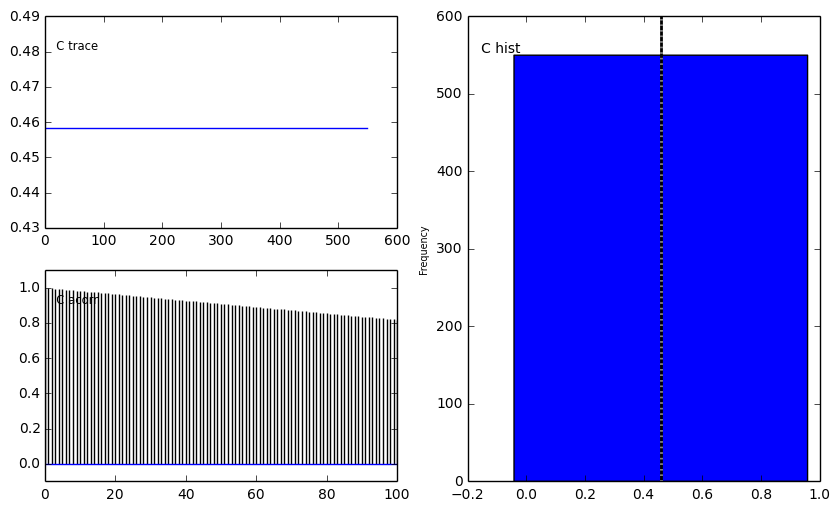

In [219]:
pymc.Matplot.plot(M)

In [92]:
nr_samples=10000
        
samp=inverse_transform_sampling(.6,nr_samples,1000)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/quadpack.py:293: UserWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/scipy/integrate/quadpack.py:293: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg)


In [208]:
observations=[x for x in samp/float(1000) if x < 1/float(2)]
[pxn(x,.6,1) for x in observations]

[1.713822547073222,
 2.201394547941149,
 1.7925554377950603,
 1.946412833079749,
 1.728137172594991,
 2.0717037822746533,
 2.2234773946864945,
 2.0494229299514397,
 1.856284368758959,
 2.0596764670516716,
 1.749833601872147,
 2.3044424474675678,
 2.2834540163954471,
 2.4344868998647438,
 2.166877712490709,
 2.1813446578765125,
 1.951275840002392,
 1.7747523663044473,
 1.744021393459414,
 2.4426001863720925,
 1.870232637303288,
 1.6236241874153752,
 1.847043363703978,
 2.4003050011824101,
 1.8624707100876767,
 2.0613903704684531,
 1.915893991493232,
 2.3430987166439525,
 1.6785525890656403,
 2.1759082690510816,
 2.1904355060573164,
 2.4304403680546796,
 1.7109738821434899,
 1.7747523663044473,
 2.1759082690510816,
 1.6729771460812648,
 2.1977354553145911,
 1.7866013254813549,
 2.4043013594838953,
 2.1489288809409572,
 2.287255825086421,
 1.6925726238540164,
 2.4063020330755549,
 2.366603040263386,
 2.3353159320076466,
 2.2815554824269038,
 2.134676920964667,
 2.2346017495596424,
 1.8332

In [205]:
pxn2(.5,.6)

1.6128561126127094

In [228]:
import pymc
import numpy as np


n = 5*np.ones(4,dtype=int)
x = np.array([-0.86,-0.3,-0.05,.73])


alpha = pymc.Normal('alpha',mu=0,tau=.01)
beta = pymc.Normal('beta',mu=0,tau=.01)


@pymc.deterministic
def theta(a=alpha, b=beta):
	    """theta = logit^{−1}(a+b)"""
            return pymc.invlogit(a+b*x)


d = pymc.Binomial('d', n=n, p=theta, value=np.array([0.,1.,3.,5.]),
                         observed=True)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.1 secPlotting theta_0
Plotting theta_1
Plotting theta_2
Plotting theta_3


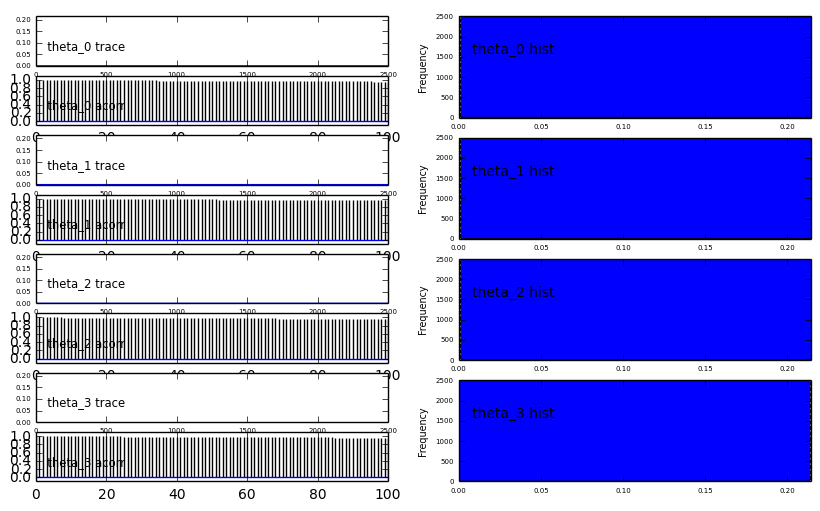

In [230]:
S = pymc.MCMC([theta],db='pickle')
S.sample(iter = 10000, burn = 5000, thin = 2)
pymc.Matplot.plot(S)

In [226]:
pymc.Matplot.plot(S)